# Investigate Building Sources

Benchmark the building retrieval pipeline using bounding boxes sourced from `event_weights_grid.shp`. Results are written to a GeoParquet along with per-query timing logs.

In [5]:
from pathlib import Path
import sys
import time

import geopandas as gpd
from shapely.geometry import box
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output


REPO_ROOT = Path.cwd().resolve().parents[1]
MODULE_ROOT = REPO_ROOT / 'code' / 'overture_analysis'
if str(MODULE_ROOT) not in sys.path:
    sys.path.append(str(MODULE_ROOT))

from functions.building_retriever import BuildingRetriever

DATA_DIR = REPO_ROOT / 'data'
RESULTS_DIR = DATA_DIR / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

BUILDINGS_PATH = REPO_ROOT / 'gis_data' / 'overturemaps-us-west-2' / 'release' / '2025-08-20.1' / 'theme=buildings' / 'type=building'
SHAPEFILE_PATH = DATA_DIR / 'OSM Projects' / 'Data' / 'Large-scale events' / 'event_weights_grid.shp'

print(f'Using buildings data from: {BUILDINGS_PATH}')
print(f'Reading shapefile: {SHAPEFILE_PATH}')


Using buildings data from: /workspace/gis_data/overturemaps-us-west-2/release/2025-08-20.1/theme=buildings/type=building
Reading shapefile: /workspace/data/OSM Projects/Data/Large-scale events/event_weights_grid.shp


In [6]:
retriever = BuildingRetriever(BUILDINGS_PATH)

grid_gdf = gpd.read_file(SHAPEFILE_PATH)
if grid_gdf.empty:
    raise RuntimeError('The shapefile contains no features.')

target_crs = 'EPSG:4326'
if grid_gdf.crs is None:
    grid_gdf = grid_gdf.set_crs(target_crs)
elif str(grid_gdf.crs) != target_crs:
    try:
        grid_gdf = grid_gdf.to_crs(target_crs)
    except Exception as exc:
        raise RuntimeError('Unable to reproject grid data to EPSG:4326 for bounding box filtering.') from exc

bbox_geom = box(97.345, 5.61, 105.639, 20.464)
subset = grid_gdf[grid_gdf.geometry.intersects(bbox_geom)].copy()
if subset.empty:
    raise RuntimeError('No grid features intersect the specified bounding box.')

print(f'Loaded {len(grid_gdf)} total features; using {len(subset)} within bounding box for benchmarking.')


Loaded 10136 total features; using 59 within bounding box for benchmarking.


In [7]:
parquet_path = RESULTS_DIR / 'buildings_investigation_result.parquet'
log_path = RESULTS_DIR / 'buildings_investigation_log.csv'

results_records, log_rows = retriever.collect_bbox_statistics(
    subset,
    geometry_field='geometry',
    metadata_fields=['id', 'entities'],
    include_osm_breakdown=True,
)

clear_output(wait=True)

result_gdf = gpd.GeoDataFrame(results_records, geometry='geometry', crs=subset.crs)
if not result_gdf.empty:
    result_gdf.to_parquet(parquet_path)
    print(f'Wrote GeoParquet: {parquet_path}')
else:
    print('No results to save to GeoParquet.')

log_df = pd.DataFrame(log_rows)
if not log_df.empty:
    log_df.to_csv(log_path, index=False)
    print(f'Wrote log CSV: {log_path}')


Wrote GeoParquet: /workspace/data/results/buildings_investigation_result.parquet
Wrote log CSV: /workspace/data/results/buildings_investigation_log.csv


In [8]:
result_gdf[['id', 'entities', 'buildings_count', 'osm_buildings_count']] if not result_gdf.empty else result_gdf


,id,entities,buildings_count,osm_buildings_count
0,9810,47128.0,219914,79871
1,9824,20825.0,119144,6286
2,9825,25802.0,262106,95829
3,9826,82956.0,1421523,35440
4,9827,74251.0,1709548,34295
5,9828,53056.0,1027852,17528
6,9829,25982.0,430532,43367
7,9842,23580.0,608637,15621
8,9855,30743.0,1303626,22224
9,9856,51848.0,311666,68799


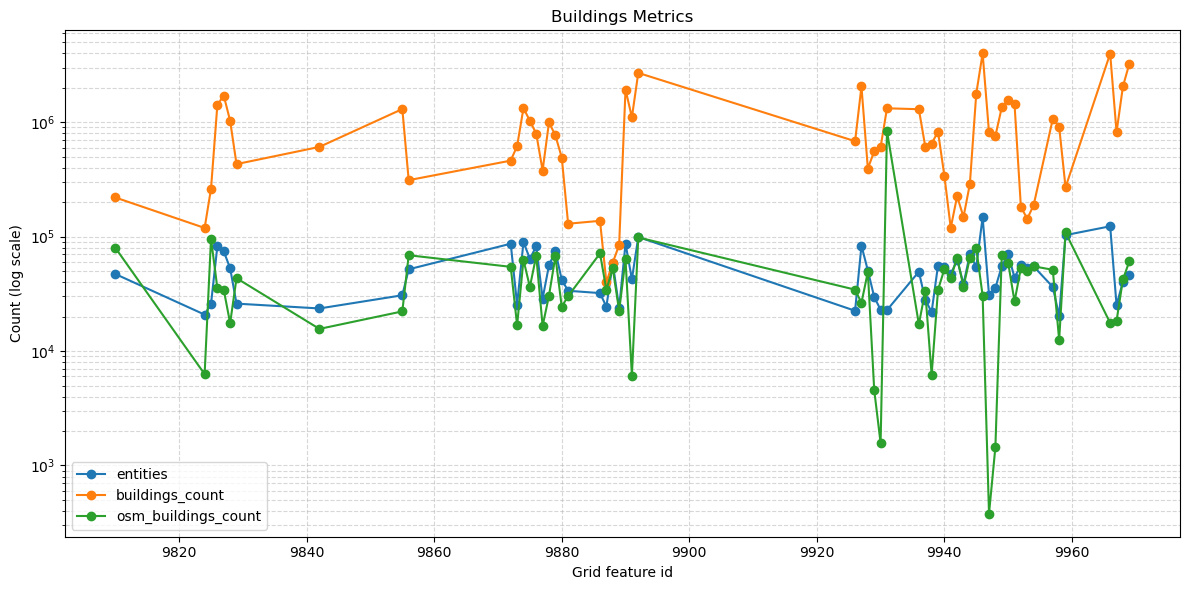

,id,entities,buildings_count,osm_buildings_count
0,9810,47128.0,219914,79871
1,9824,20825.0,119144,6286
2,9825,25802.0,262106,95829
3,9826,82956.0,1421523,35440
4,9827,74251.0,1709548,34295


In [19]:
analysis_df = pd.read_parquet(parquet_path)
if analysis_df.empty:
    raise RuntimeError('No data found in buildings_investigation_result.parquet.')

chart_df = analysis_df.sort_values('id')
ax = chart_df.plot(
    x='id',
    y=['entities', 'buildings_count', 'osm_buildings_count'],
    kind='line',
    figsize=(12, 6),
    marker='o'
)
ax.set_title('Buildings Metrics')
ax.set_xlabel('Grid feature id')
ax.set_ylabel('Count (log scale)')
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
chart_df[['id', 'entities', 'buildings_count', 'osm_buildings_count']].head()


In [9]:
retriever.close()
